# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_084  Q6YHK3            14.025
Sample_007  A0A0B4J1V2        14.379
Sample_079  Q9UBR2            18.784
Sample_084  Q06033;Q06033-2   17.589
Sample_199  P35527            13.218
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups            
Sample_184  P49257                       17.034
Sample_168  A0A140T9S5;Q9Y334;Q9Y334-2   13.785
Sample_206  Q15465                       15.459
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.637
            A0A075B6Q5                 12.868
            A0A075B6R2                 12.312
            A0A075B6S5                 13.273
            A0A087WSY4                 12.295
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.685
            Q9UI40;Q9UI40-2            14.392
            Q9UIW2                     13.693
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.604
            Q9UP79                     12.047
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.222,15.050,16.842,19.863,15.925,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.763,19.067,...,15.528,15.576,14.094,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.796,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.575,17.705,17.039,16.067,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.771,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.452,15.345,17.084,18.708,14.249,19.433,10.881,11.499
Sample_207,15.739,16.877,15.469,16.898,14.826,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.298,12.313,13.977,14.345,13.746,13.515,12.112,12.311,12.257,13.930
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.063,19.067,16.127,...,11.291,12.514,13.216,13.283,12.318,11.042,12.836,12.793,11.744,12.466
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.880,12.382,11.297,14.201,12.513,12.299,13.062,13.077,12.187,12.841
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.200,13.008,12.155,13.007,11.318,13.906,14.074,14.531,12.661,13.644
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.493,13.195,13.257,12.235,13.130,12.284,14.017,12.553,12.537,13.274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.344,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 375.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.98it/s]

100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.59it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

100%|██████████| 4/4 [00:01<00:00,  3.43it/s]

100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.98it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.14it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.38it/s]

100%|██████████| 5/5 [00:01<00:00,  3.21it/s]

100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.51it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.41it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.15it/s]

100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.28it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.96it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.36it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.09it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.98it/s]

100%|██████████| 7/7 [00:02<00:00,  3.15it/s]

100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 10.12it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.67it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.92it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.61it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.62it/s]

100%|██████████| 8/8 [00:01<00:00,  3.90it/s]

100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.06it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.15it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.43it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.71it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.37it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.18it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.11it/s]

100%|██████████| 9/9 [00:02<00:00,  3.26it/s]

100%|██████████| 9/9 [00:02<00:00,  3.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.52it/s]

 30%|███       | 3/10 [00:00<00:01,  6.56it/s]

 40%|████      | 4/10 [00:00<00:01,  5.97it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.87it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.92it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.56it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.49it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.29it/s]

100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

100%|██████████| 10/10 [00:02<00:00,  3.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.66it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.19it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.63it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.20it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.55it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.93it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.37it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.50it/s]

100%|██████████| 11/11 [00:02<00:00,  3.85it/s]

100%|██████████| 11/11 [00:02<00:00,  4.43it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.08it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.59it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.26it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.88it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.77it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.06it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.58it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.41it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.19it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.09it/s]

100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

100%|██████████| 12/12 [00:03<00:00,  3.93it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.46it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.49it/s]

 31%|███       | 4/13 [00:00<00:01,  5.78it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.19it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.85it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.58it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.38it/s]

 69%|██████▉   | 9/13 [00:01<00:01,  3.65it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.34it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.16it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.01it/s]

100%|██████████| 13/13 [00:03<00:00,  2.98it/s]

100%|██████████| 13/13 [00:03<00:00,  3.82it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.84it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.83it/s]

 29%|██▊       | 4/14 [00:00<00:01,  6.04it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.73it/s]

 43%|████▎     | 6/14 [00:01<00:01,  5.31it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.21it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.17it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.15it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.08it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  5.20it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.77it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.36it/s]

100%|██████████| 14/14 [00:02<00:00,  3.87it/s]

100%|██████████| 14/14 [00:02<00:00,  4.90it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.32it/s]

 27%|██▋       | 4/15 [00:00<00:01,  5.87it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.55it/s]

 40%|████      | 6/15 [00:01<00:01,  5.48it/s]

 47%|████▋     | 7/15 [00:01<00:01,  5.38it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.21it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.22it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.11it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  5.12it/s]

 80%|████████  | 12/15 [00:02<00:00,  5.10it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.14it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.56it/s]

100%|██████████| 15/15 [00:02<00:00,  5.27it/s]

100%|██████████| 15/15 [00:02<00:00,  5.44it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.040 0.012          0.731 0.366       0.104   
2             0.003 0.002      0.038 0.010          0.710 0.091       0.601   
3             0.003 0.001      0.030 0.012          0.718 0.086       0.653   
4             0.004 0.003      0.037 0.011          0.710 0.079       0.676   
5             0.004 0.003      0.039 0.012          0.727 0.084       0.694   
6             0.003 0.000      0.039 0.013          0.792 0.087       0.816   
7             0.004 0.002      0.037 0.007          0.794 0.086       0.825   
8             0.004 0.003      0.033 0.010          0.817 0.082       0.815   
9             0.003 0.002      0.038 0.020          0.799 0.076       0.833   
10            0.004 0.003      0.033 0.013          0.807 0.081       0.840   
11            0.003 0.001      0.034 0.011          0.800 0.085       0.841   
12            0.004 0.004      0.041 0.014          0.807 0.082       0.838   
13            0.004 0.002      0.039 0.015          0.802 0.083       0.835   
14            0.004 0.001      0.034 0.012          0.799 0.082       0.836   
15            0.004 0.003      0.038 0.015          0.803 0.086       0.832   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.175 0.125                  0.544 0.038        0.847   
2          0.103   0.645 0.079                  0.709 0.058        0.779   
3          0.113   0.677 0.080                  0.730 0.059        0.799   
4          0.115   0.686 0.076                  0.735 0.057        0.797   
5          0.112   0.703 0.072                  0.749 0.056        0.807   
6          0.103   0.799 0.070                  0.827 0.062        0.893   
7          0.105   0.804 0.070                  0.832 0.061        0.893   
8          0.111   0.811 0.076                  0.840 0.065        0.909   
9          0.104   0.812 0.070                  0.839 0.061        0.911   
10         0.100   0.819 0.071                  0.845 0.063        0.911   
11         0.107   0.816 0.075                  0.842 0.067        0.909   
12         0.106   0.818 0.073                  0.844 0.064        0.907   
13         0.103   0.815 0.075                  0.841 0.066        0.906   
14         0.105   0.813 0.072                  0.840 0.064        0.904   
15         0.097   0.813 0.066                  0.839 0.058        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.822 0.088        210.000 0.000  
2          0.067                  0.757 0.085        210.000 0.000  
3          0.067                  0.767 0.088        210.000 0.000  
4          0.063                  0.761 0.084        210.000 0.000  
5          0.063                  0.778 0.083        210.000 0.000  
6          0.052                  0.867 0.060        210.000 0.000  
7          0.051                  0.866 0.061        210.000 0.000  
8          0.050                  0.898 0.050        210.000 0.000  
9          0.052                  0.902 0.049        210.000 0.000  
10         0.052                  0.904 0.049        210.000 0.000  
11         0.054                  0.901 0.051        210.000 0.000  
12         0.053                  0.897 0.051        210.000 0.000  
13         0.054                  0.897 0.052        210.000 0.000  
14         0.054                  0.895 0.051        210.000 0.000  
15         0.052                  0.893 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 572.99it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 13.11it/s]

100%|██████████| 3/3 [00:00<00:00,  9.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.79it/s]

100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

100%|██████████| 4/4 [00:00<00:00,  8.27it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 12.60it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.90it/s]

100%|██████████| 5/5 [00:00<00:00,  7.31it/s]

100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 12.58it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.32it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.79it/s]

100%|██████████| 6/6 [00:00<00:00,  5.92it/s]

100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 12.01it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.70it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  7.26it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.98it/s]

100%|██████████| 7/7 [00:00<00:00,  6.65it/s]

100%|██████████| 7/7 [00:00<00:00,  7.20it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.40it/s]

 50%|█████     | 4/8 [00:00<00:00,  7.41it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  7.17it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.86it/s]

 88%|████████▊ | 7/8 [00:00<00:00,  6.59it/s]

100%|██████████| 8/8 [00:01<00:00,  6.44it/s]

100%|██████████| 8/8 [00:01<00:00,  6.94it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 12.71it/s]

 44%|████▍     | 4/9 [00:00<00:00,  7.46it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.96it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  5.75it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  5.63it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.81it/s]

100%|██████████| 9/9 [00:01<00:00,  5.82it/s]

100%|██████████| 9/9 [00:01<00:00,  6.18it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.92it/s]

 40%|████      | 4/10 [00:00<00:00,  6.97it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.69it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.55it/s]

 70%|███████   | 7/10 [00:01<00:00,  6.48it/s]

 80%|████████  | 8/10 [00:01<00:00,  6.45it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.41it/s]

100%|██████████| 10/10 [00:01<00:00,  5.38it/s]

100%|██████████| 10/10 [00:01<00:00,  6.26it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.48it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.89it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.37it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.37it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.33it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.27it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.17it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.10it/s]

100%|██████████| 11/11 [00:01<00:00,  6.18it/s]

100%|██████████| 11/11 [00:01<00:00,  6.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 14.53it/s]

 33%|███▎      | 4/12 [00:00<00:01,  6.39it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.98it/s]

 50%|█████     | 6/12 [00:00<00:01,  5.88it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  5.85it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.96it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.08it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.08it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.14it/s]

100%|██████████| 12/12 [00:01<00:00,  6.11it/s]

100%|██████████| 12/12 [00:01<00:00,  6.24it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.06it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.52it/s]

 31%|███       | 4/13 [00:00<00:01,  5.91it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.57it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.23it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.15it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.09it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.04it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.07it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  5.01it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  5.03it/s]

100%|██████████| 13/13 [00:02<00:00,  4.58it/s]

100%|██████████| 13/13 [00:02<00:00,  5.18it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 10.18it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.90it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.31it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.11it/s]

 50%|█████     | 7/14 [00:00<00:01,  6.89it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.80it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.45it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.41it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.45it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.50it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.65it/s]

100%|██████████| 14/14 [00:02<00:00,  6.36it/s]

100%|██████████| 14/14 [00:02<00:00,  6.80it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.74it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.22it/s]

 33%|███▎      | 5/15 [00:00<00:01,  8.90it/s]

 40%|████      | 6/15 [00:00<00:01,  8.50it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.34it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.24it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.28it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.38it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.45it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.49it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.34it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.20it/s]

100%|██████████| 15/15 [00:01<00:00,  8.11it/s]

100%|██████████| 15/15 [00:01<00:00,  8.48it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.021 0.003          0.010 0.071       0.001   
2             0.003 0.001      0.028 0.007          0.665 0.137       0.440   
3             0.002 0.000      0.020 0.002          0.686 0.101       0.516   
4             0.002 0.000      0.021 0.004          0.764 0.101       0.680   
5             0.002 0.001      0.021 0.004          0.774 0.099       0.681   
6             0.002 0.000      0.020 0.000          0.771 0.095       0.682   
7             0.002 0.003      0.022 0.008          0.785 0.094       0.702   
8             0.002 0.001      0.023 0.005          0.782 0.095       0.710   
9             0.002 0.000      0.021 0.004          0.777 0.093       0.709   
10            0.002 0.000      0.021 0.003          0.779 0.094       0.736   
11            0.002 0.001      0.023 0.005          0.760 0.083       0.787   
12            0.003 0.001      0.026 0.011          0.757 0.092       0.788   
13            0.003 0.002      0.034 0.014          0.788 0.083       0.817   
14            0.002 0.000      0.021 0.002          0.780 0.080       0.799   
15            0.002 0.000      0.020 0.001          0.783 0.087       0.791   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.854   
2          0.115   0.518 0.098                  0.633 0.062        0.685   
3          0.113   0.581 0.090                  0.670 0.057        0.678   
4          0.118   0.714 0.093                  0.762 0.073        0.864   
5          0.122   0.718 0.091                  0.766 0.069        0.870   
6          0.119   0.718 0.089                  0.766 0.068        0.867   
7          0.110   0.735 0.080                  0.779 0.062        0.880   
8          0.118   0.738 0.086                  0.781 0.067        0.878   
9          0.119   0.736 0.091                  0.779 0.070        0.877   
10         0.117   0.752 0.090                  0.791 0.072        0.878   
11         0.130   0.766 0.084                  0.801 0.069        0.897   
12         0.129   0.765 0.087                  0.800 0.073        0.897   
13         0.108   0.798 0.075                  0.827 0.063        0.908   
14         0.120   0.785 0.081                  0.817 0.067        0.907   
15         0.113   0.781 0.077                  0.814 0.063        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.823 0.087        210.000 0.000  
2          0.088                  0.661 0.094        210.000 0.000  
3          0.076                  0.666 0.085        210.000 0.000  
4          0.059                  0.830 0.076        210.000 0.000  
5          0.058                  0.836 0.072        210.000 0.000  
6          0.057                  0.833 0.071        210.000 0.000  
7          0.057                  0.848 0.071        210.000 0.000  
8          0.059                  0.845 0.073        210.000 0.000  
9          0.060                  0.844 0.073        210.000 0.000  
10         0.061                  0.846 0.076        210.000 0.000  
11         0.053                  0.865 0.066        210.000 0.000  
12         0.051                  0.863 0.062        210.000 0.000  
13         0.049                  0.884 0.059        210.000 0.000  
14         0.050                  0.882 0.060        210.000 0.000  
15         0.047                  0.900 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1444.82it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 49.75it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 51.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.33it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 43.45it/s]

100%|██████████| 5/5 [00:00<00:00, 43.23it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 42.88it/s]

100%|██████████| 6/6 [00:00<00:00, 38.33it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 42.58it/s]

100%|██████████| 7/7 [00:00<00:00, 40.16it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 44.20it/s]

100%|██████████| 8/8 [00:00<00:00, 40.50it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 43.72it/s]

100%|██████████| 9/9 [00:00<00:00, 39.29it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 43.89it/s]

100%|██████████| 10/10 [00:00<00:00, 38.06it/s]

100%|██████████| 10/10 [00:00<00:00, 38.74it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.19it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.77it/s]

100%|██████████| 11/11 [00:00<00:00, 39.01it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 44.10it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.31it/s]

100%|██████████| 12/12 [00:00<00:00, 38.29it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.50it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.46it/s]

100%|██████████| 13/13 [00:00<00:00, 38.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 43.50it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.23it/s]

100%|██████████| 14/14 [00:00<00:00, 37.14it/s]

100%|██████████| 14/14 [00:00<00:00, 37.87it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.75it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 38.50it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.25it/s]

100%|██████████| 15/15 [00:00<00:00, 37.82it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.020 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.020 0.000          0.672 0.130       0.469   
3             0.002 0.000      0.020 0.001          0.673 0.128       0.470   
4             0.002 0.000      0.020 0.000          0.653 0.138       0.457   
5             0.002 0.000      0.020 0.001          0.689 0.116       0.541   
6             0.002 0.000      0.020 0.001          0.657 0.117       0.525   
7             0.002 0.000      0.020 0.000          0.661 0.095       0.575   
8             0.002 0.000      0.020 0.000          0.657 0.094       0.571   
9             0.002 0.000      0.020 0.000          0.657 0.102       0.571   
10            0.002 0.000      0.020 0.000          0.676 0.095       0.576   
11            0.002 0.000      0.020 0.000          0.673 0.081       0.583   
12            0.002 0.000      0.020 0.000          0.664 0.081       0.582   
13            0.002 0.000      0.020 0.000          0.660 0.080       0.577   
14            0.002 0.000      0.020 0.000          0.673 0.089       0.600   
15            0.002 0.000      0.020 0.000          0.668 0.095       0.600   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.736   
2          0.103   0.547 0.102                  0.650 0.067        0.712   
3          0.113   0.546 0.102                  0.649 0.067        0.707   
4          0.108   0.532 0.111                  0.638 0.074        0.702   
5          0.098   0.600 0.088                  0.678 0.065        0.753   
6          0.114   0.575 0.091                  0.658 0.065        0.779   
7          0.112   0.609 0.087                  0.678 0.067        0.793   
8          0.115   0.605 0.089                  0.675 0.067        0.789   
9          0.118   0.604 0.093                  0.675 0.071        0.785   
10         0.111   0.616 0.084                  0.685 0.064        0.787   
11         0.112   0.619 0.080                  0.687 0.060        0.783   
12         0.114   0.615 0.082                  0.683 0.061        0.780   
13         0.113   0.610 0.080                  0.679 0.060        0.778   
14         0.120   0.628 0.089                  0.692 0.066        0.776   
15         0.116   0.626 0.087                  0.689 0.066        0.771   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.684 0.085        210.000 0.000  
2          0.071                  0.676 0.085        210.000 0.000  
3          0.076                  0.671 0.087        210.000 0.000  
4          0.078                  0.675 0.088        210.000 0.000  
5          0.074                  0.711 0.088        210.000 0.000  
6          0.070                  0.726 0.088        210.000 0.000  
7          0.063                  0.742 0.082        210.000 0.000  
8          0.063                  0.738 0.082        210.000 0.000  
9          0.065                  0.735 0.083        210.000 0.000  
10         0.061                  0.735 0.078        210.000 0.000  
11         0.061                  0.732 0.078        210.000 0.000  
12         0.061                  0.725 0.080        210.000 0.000  
13         0.062                  0.721 0.082        210.000 0.000  
14         0.062                  0.728 0.080        210.000 0.000  
15         0.063                  0.725 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,13,15
score_time,12,13,3
test_precision,8,13,5
test_recall,11,13,15
test_f1,10,13,14
test_balanced_accuracy,10,13,14
test_roc_auc,10,15,7
test_average_precision,10,15,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.87it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.36it/s]

 40%|████      | 6/15 [00:00<00:00,  9.48it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.96it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.78it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.75it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.72it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.64it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.64it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.45it/s]

100%|██████████| 15/15 [00:01<00:00,  8.52it/s]

100%|██████████| 15/15 [00:01<00:00,  8.99it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 44.20it/s]

100%|██████████| 7/7 [00:00<00:00, 41.25it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 19.75it/s]

 40%|████      | 4/10 [00:00<00:00, 11.93it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.54it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.16it/s]

100%|██████████| 10/10 [00:00<00:00,  9.96it/s]

100%|██████████| 10/10 [00:00<00:00, 10.55it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


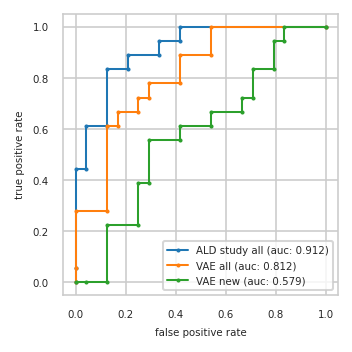

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.444   0.000 0.278   0.125 0.000
3          0.042 0.444   0.125 0.278   0.125 0.222
4          0.042 0.611   0.125 0.611   0.250 0.222
5          0.125 0.611   0.167 0.611   0.250 0.389
6          0.125 0.833   0.167 0.667   0.292 0.389
7          0.208 0.833   0.250 0.667   0.292 0.556
8          0.208 0.889   0.250 0.722   0.417 0.556
9          0.333 0.889   0.292 0.722   0.417 0.611
10         0.333 0.944   0.292 0.778   0.542 0.611
11         0.417 0.944   0.417 0.778   0.542 0.667
12         0.417 1.000   0.417 0.889   0.667 0.667
13         1.000 1.000   0.542 0.889   0.667 0.722
14           NaN   NaN   0.542 1.000   0.708 0.722
15           NaN   NaN   1.000 1.000   0.708 0.833
16           NaN   NaN     NaN   NaN   0.792 0.833
17           NaN   NaN     NaN   NaN   0.792 0.944
18           NaN   NaN     NaN   NaN   0.833 0.944
19           NaN   NaN     NaN   NaN   0.833 1.000
20           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A0J9YX35,K7ER15;Q9H0R4;Q9H0R4-2,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2
2,P01258;P01258-2;P06881,P02741,P31321
3,P61981,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
4,P14174,P61981,E9PK25;G3V1A4;P23528
5,P04075,Q9Y2T3;Q9Y2T3-3,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6
6,Q9Y2T3;Q9Y2T3-3,P25189;P25189-2,Q96GD0
7,P08294,P63104,None
8,P00338;P00338-3,P00492,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


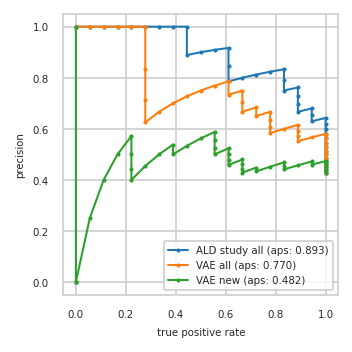

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.452 0.778
12         0.600 1.000     0.567 0.944     0.433 0.722
13         0.621 1.000     0.552 0.889     0.448 0.722
14         0.643 1.000     0.571 0.889     0.429 0.667
15         0.630 0.944     0.593 0.889     0.444 0.667
16         0.654 0.944     0.615 0.889     0.462 0.667
17         0.680 0.944     0.600 0.833     0.480 0.667
18         0.667 0.889     0.583 0.778     0.458 0.611
19         0.696 0.889     0.609 0.778     0.478 0.611
20         0.727 0.889     0.636 0.778     0.500 0.611
21         0.762 0.889     0.667 0.778     0.524 0.611
22         0.750 0.833     0.650 0.722     0.500 0.556
23         0.789 0.833     0.684 0.722     0.526 0.556
24         0.833 0.833     0.667 0.667     0.556 0.556
25         0.824 0.778     0.706 0.667     0.588 0.556
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.800 0.667     0.733 0.611     0.533 0.444
28         0.786 0.611     0.786 0.611     0.500 0.389
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.917 0.611     0.750 0.500     0.500 0.333
31         0.909 0.556     0.727 0.444     0.455 0.278
32         0.900 0.500     0.700 0.389     0.400 0.222
33         0.889 0.444     0.667 0.333     0.444 0.222
34         1.000 0.444     0.625 0.278     0.500 0.222
35         1.000 0.389     0.714 0.278     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.000 0.000
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


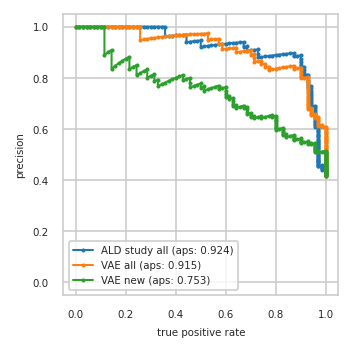

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


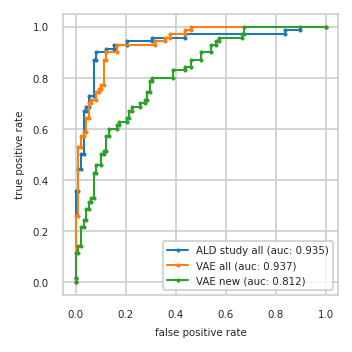

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}